#### FORWARD SOLVER: game(p,E,s, b, C) ==> (x, v)

In [1]:
include("entropy_routing_solver_nlsolve.jl")
# include("solve_entropy_routing_jump.jl")


# calling by:
# x, v = solve_entropy_routing(pa(), 0.01)

solve_entropy_routing (generic function with 1 method)

#### BACKWARD SOLVER: (p,E,s, x_hat) ==> (b, C)

In [2]:
include("approx_proj_gradient.jl")
# calling by:
# x, b, C, ψ_vals, violation_metrics, lambda_vals, v, ∇̂ψ_C_norm, D_norm, J_norm, pinv_J_norm, F_norm = approx_proj_grad(p, E, s, x̂, λ, α, ϵ, ρ, max_iter, x, b, C)

" RUNNING "

#### ROUTING GAME LIBRARY

In [3]:
include("routing_games.jl")
# calling by
# game_name, g, p, E, s, x̂ = grid_graph3_4_players()

plot_labeled (generic function with 1 method)

#### RUNNING

In [4]:
function homotopy_exp_parameter_choice(p, E, s, x̂, λ_list, α, ϵ, ρ, max_iter)
    n, m = size(E)

    # output placeholder
    x = zeros(p*m)
    b = 0.1*ones(p*m)
    C = zeros(p*m, p*m)
    v = zeros(p*n)
    
    ψ_vals_list = Float64[]
    violation_metrics_list = Float64[]
    lambda_vals_list = Float64[]
    ∇̂ψ_C_norm_list = Float64[]
    D_norm_list = Float64[]
    J_norm_list = Float64[]
    pinv_J_norm_list = Float64[]
    F_norm_list = Float64[]

    for λ in λ_list
        println("λ=$λ, α=$α")
        x, b, C, ψ_vals, violation_metrics, lambda_vals, v, ∇̂ψ_C_norm, D_norm, J_norm, pinv_J_norm, F_norm = approx_proj_grad(p, E, s, x̂, λ, α, ϵ, ρ, max_iter, x, b, C)
        append!(ψ_vals_list, ψ_vals)
        append!(violation_metrics_list, violation_metrics)
        append!(lambda_vals_list, lambda_vals)
        append!(∇̂ψ_C_norm_list, ∇̂ψ_C_norm)
        append!(D_norm_list, D_norm)
        append!(J_norm_list, J_norm)
        append!(pinv_J_norm_list, pinv_J_norm)
        append!(F_norm_list, F_norm)
    end
    
    (;x = x,
      b = b,
      C = C,
      ψ_vals_list = ψ_vals_list,
      violation_metrics_list = violation_metrics_list,
      lambda_vals_list = lambda_vals_list,
      v = v,
      ∇̂ψ_C_norm_list = ∇̂ψ_C_norm_list,
      D_norm_list = D_norm_list,
      J_norm_list = J_norm_list,
      pinv_J_norm_list = pinv_J_norm_list,
      F_norm_list = F_norm_list)
end

homotopy_exp_parameter_choice (generic function with 1 method)

In [5]:
using JLD2

# instantiate a routing game (p, E, s) with desired Nash sol x̂
game_name, g, p, E, s, x̂ = grid_graph3_4_players()

# assign parameters
α = 0.005
ϵ = 1e-3
ρ = 0.5
max_iter = 10
@show λ_list = [1.0/(2^i) for i in 5:10]

# create an individual folder under homotopy_results/
dir = "homotopy_results/$(game_name)"; mkpath(dir) # mkdir if not exists

λ_list = [1.0 / 2 ^ i for i = 5:10] = [0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625]


"homotopy_results/grid_graph3_4_players"

In [6]:
""" RUNNING EXP: PARAMETER CHOICE """
# calling method
println("----------- $(game_name)_ρ=($ρ)_λ_list=($λ_list)_α=($α)_ϵ=($ϵ) -----------")
x, b, C, ψ_vals_list, violation_metrics_list, lambda_vals_list, v, ∇̂ψ_C_norm_list, D_norm_list, J_norm_list, pinv_J_norm_list, F_norm_list = homotopy_exp_parameter_choice(p, E, s, x̂, λ_list, α, ϵ, ρ, max_iter)

# save data to folder
println("saving result to '$dir/$(game_name)_λ_list=($λ_list)_homotopy.jld2'")
@save "$dir/$(game_name)_λ_list=($λ_list)_homotopy.jld2" ρ λ_list α ϵ max_iter lambda_vals_list ψ_vals_list violation_metrics_list v ∇̂ψ_C_norm_list D_norm_list J_norm_list pinv_J_norm_list F_norm_list
println("--------------------------------")

----------- grid_graph3_4_players_ρ=(0.5)_λ_list=([0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625])_α=(0.005)_ϵ=(0.001) -----------
λ=0.03125, α=0.005
Starting approx proj grad...
λ=0.015625, α=0.005
Starting approx proj grad...
λ=0.0078125, α=0.005
Starting approx proj grad...
λ=0.00390625, α=0.005
Starting approx proj grad...
λ=0.001953125, α=0.005
Starting approx proj grad...
λ=0.0009765625, α=0.005
Starting approx proj grad...
saving result to 'homotopy_results/grid_graph3_4_players/grid_graph3_4_players_λ_list=([0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625])_homotopy.jld2'
--------------------------------


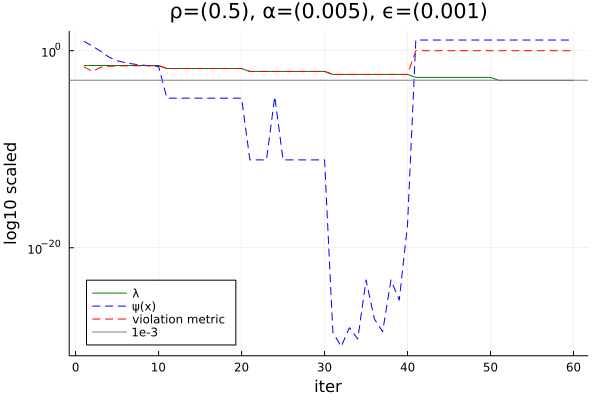

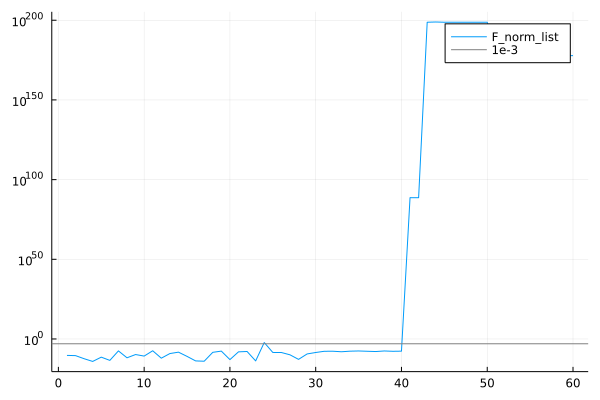

saving plot to 'homotopy_results/grid_graph3_4_players/grid_graph3_4_players_λ_list=([0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625])_homotopy.png'
saving plot to 'homotopy_results/grid_graph3_4_players/grid_graph3_4_players_λ_list=([0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625])_helper_metrics.png'


In [7]:
using Plots, IJulia
mkpath("current_homotopy")

@load "$dir/$(game_name)_λ_list=($λ_list)_homotopy.jld2" ρ λ_list α ϵ max_iter lambda_vals_list ψ_vals_list violation_metrics_list v ∇̂ψ_C_norm_list D_norm_list J_norm_list pinv_J_norm_list F_norm_list

# plot single axis (log-scaled)
p1 = plot(lambda_vals_list, yscale=:log10, c=:green, label="λ", leg=:bottomleft, xlabel="iter", ylabel="log10 scaled")
plot!(ψ_vals_list, yscale=:log10, c=:blue, linestyle=:dash, label="ψ(x)", leg=:bottomleft)
plot!(violation_metrics_list, yscale=:log10, c=:red, linestyle=:dash, label="violation metric", leg=:bottomleft)
hline!([1e-3], label="1e-3", c=:grey)
plot!(title="ρ=($ρ), α=($α), ϵ=($ϵ)")
println("saving plot to '$dir/$(game_name)_λ_list=($λ_list)_homotopy.png'")
savefig("$dir/$(game_name)_λ_list=($λ_list)_homotopy.png")
IJulia.display(p1)

# plot helper_metrics_plot
# plot!(pinv_J_norm_list, label="pinv_J_norm_list", yscale=:log10)
p2 = plot(F_norm_list, label="F_norm_list", yscale=:log10)
# plot!(∇̂ψ_C_norm_list, label="∇̂ψ_C_norm_list", yscale=:log10, leg=:bottomleft)
# plot!(D_norm_list, label="D_norm_list", yscale=:log10)
# plot!(J_norm_list, label="J_norm_list", yscale=:log10)
hline!([1e-3], label="1e-3", c=:grey)
println("saving plot to '$dir/$(game_name)_λ_list=($λ_list)_helper_metrics.png'")
savefig("$dir/$(game_name)_λ_list=($λ_list)_helper_metrics.png")
IJulia.display(p2)